# YanuX Cruncher Metrics Notebook #

In [1]:
%matplotlib inline

## Imports ##

In [2]:
#Python Standard Library
import sys
import math
import collections
#Pandas
import pandas as pd
#NumPy
import numpy as np                    
#SciPy
import scipy as sp
#Matplotlib
import matplotlib.pyplot as plt       
#scikit-learn
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
import sklearn.metrics
#YanuX Cruncher
from yanux.cruncher.model.loader import JsonLoader
from yanux.cruncher.model.wifi import WifiLogs

## Load Data ##

In [3]:
json_loader = JsonLoader('data')
wifi_logs = WifiLogs(json_loader.json_data)
# Shuffle data to remove any bias
# wifi_logs.shuffle_samples()

Load the data as individual Wi-Fi Results, i.e., each line represents a single Access Point (AP) signal strength measurement.

(NOTE: Data is being separately loaded as train and test sets)

In [4]:
wifi_results_columns=["filename", "x", "y", "floor", "sample_id", "mac_address", "timestamp", "signal_strength"]
wifi_results_all = pd.DataFrame(wifi_logs.wifi_results(), columns=wifi_results_columns)

Load the data as aggregated Wi-Fi Sample, i.e., each line represents a point in time at which a scan for Wi-Fi networks was performed. Each column beyond *filename*, *x*, *y*, *floor*, *sample_id* and *timestamp* represents a different AP and the values at each of those columns are the AP's signal strength when each of the samples was taken.

Whenever a sample didn't capture an AP's signal, either because it was completely out of range, or because the signal was so weak that it was just ignored by the hardware and software stack, the value was considered to an arbitrarly low value.

(NOTE: Data is being separately loaded as train and test sets)

In [5]:
mac_addresses = wifi_results_all.mac_address.unique()
wifi_samples_columns = ["filename", "x", "y", "floor", "sample_id", "timestamp"]
wifi_samples_columns.extend(mac_addresses)

wifi_samples_all = pd.DataFrame(wifi_logs.wifi_samples(), columns=wifi_samples_columns)
# wifi_samples_train = pd.DataFrame(wifi_logs.wifi_samples(0,train_test_data_split_index),
#                                   columns=wifi_samples_columns)
# wifi_samples_test = pd.DataFrame(wifi_logs.wifi_samples(train_test_data_split_index, num_samples_per_location),
#                                 columns=wifi_samples_columns)

wifi_samples_train = wifi_samples_all.query("(x == 0.0 and y == 0.5)"
                                      + " or (x == 4.0 and y == 0.5)"
                                      + " or (x == 8.0 and y == 0.5)"
                                      + " or (x == 12.0 and y == 0.5)"
                                      + " or (x == 13.5 and y == 3.0)"
                                      + " or (x == 13.5 and y == 7.0)"
                                      + " or (x == 13.5 and y == 11.0)"
                                      + " or (x == 17.5 and y == 11.0)"
                                      + " or (x == 21.5 and y == 11.0)"
                                      + " or (x == 25.5 and y == 11.0)"
                                      + " or (x == 29.5 and y == 11.0)"
                                      + " or (x == 33.5 and y == 11.0)"
                                      + " or (x == 37.5 and y == 11.0)").reset_index(drop=True)

wifi_samples_test = wifi_samples_all.query("(x == 2.0 and y == 0.5)"
                                     + " or (x == 6.0 and y == 0.5)"
                                     + " or (x == 10.0 and y == 0.5)"
                                     + " or (x == 13.5 and y == 1.0)"
                                     + " or (x == 13.5 and y == 5.0)"
                                     + " or (x == 13.5 and y == 9.0)"
                                     + " or (x == 15.5 and y == 11.0)"
                                     + " or (x == 19.5 and y == 11.0)"
                                     + " or (x == 23.5 and y == 11.0)"
                                     + " or (x == 27.5 and y == 11.0)"
                                     + " or (x == 31.5 and y == 11.0)"
                                     + " or (x == 35.5 and y == 11.0)").reset_index(drop=True)

# not_present_signal_strength = sys.float_info.min
not_present_signal_strength = -100

wifi_samples_all = wifi_samples_all.fillna(not_present_signal_strength)
wifi_samples_train = wifi_samples_train.fillna(not_present_signal_strength)
wifi_samples_test = wifi_samples_test.fillna(not_present_signal_strength)

wifi_samples_all["error"] = 0
wifi_samples_train["error"] = 0
wifi_samples_test["error"] = 0

### Save everything to CSV ###

In [6]:
wifi_results_all.to_csv("wifi_results_all.csv")

wifi_samples_train.to_csv("wifi_samples_train.csv")
wifi_samples_test.to_csv("wifi_samples_test.csv")
wifi_samples_all.to_csv("wifi_samples_all.csv")

## Plots ##

### The coordinates of the points where data was captured ###

(-1.875, 39.375, -0.025000000000000022, 11.525)

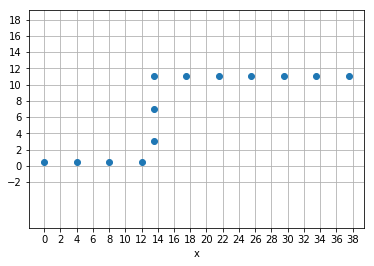

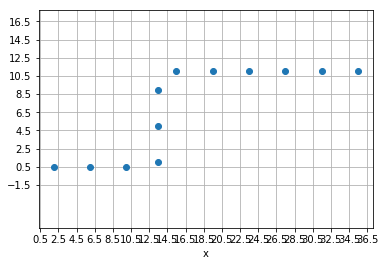

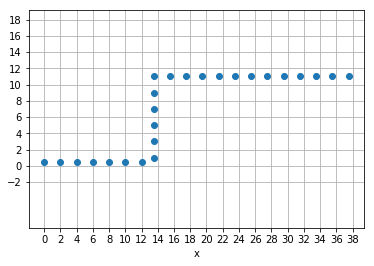

In [7]:
coords = wifi_samples_train[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

coords = wifi_samples_test[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

coords = wifi_samples_all[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

### Signal Strength Distribution ###

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7B8C7BE48>]], dtype=object)

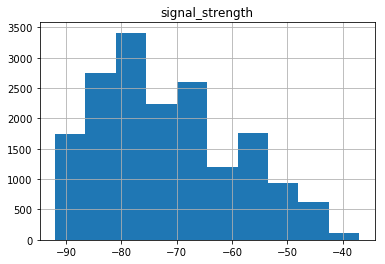

In [8]:
wifi_results_all.hist(column="signal_strength")

### How often has each Access Point been detected? ###

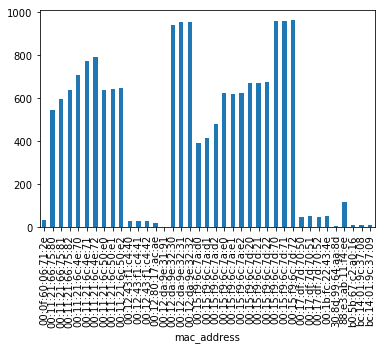

In [9]:
mac_address_group = wifi_results_all.groupby("mac_address")
mac_address_group.size().plot(kind="bar")
# mac_address_group.size()

### How many times were Wi-Fi results collected at each location? ###

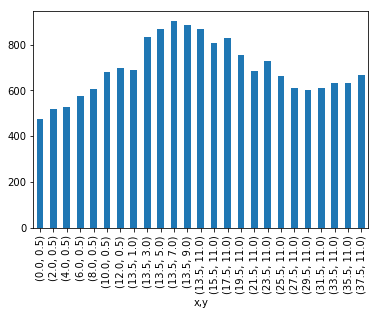

In [10]:
coord_group = wifi_results_all.groupby(["x", "y"])
coord_group.size().plot(kind="bar")
# coord_group.size()

## Positioning ##

Generalizing regression experiments

In [11]:
def regression_experiment(regressor, training_data, train_cols, target_cols, test_data, predicted_cols):
    regressor.fit(training_data[train_cols], training_data[target_cols])
    predictions = pd.DataFrame(regressor.predict(test_data[train_cols]), columns=predicted_cols)
    results = pd.concat([test_data[target_cols], predictions], axis=1)
    
    results["euclidean_distance_error"] = 0
    for col in target_cols:
        results["euclidean_distance_error"] += (results[col] - results[col+"_predicted"])**2
    results["euclidean_distance_error"] = results["euclidean_distance_error"].apply(np.sqrt)
    
    return results

Running multiple regressions experiments, with varying parameters and implementations, while collecting the results for further analysis.

In [12]:
regressors = collections.OrderedDict()
# SVR is only able to predict one coordinate at a time. I'm not sure if it is a good idea to just predict each coordinate in separate and merge them together later. Maybe is not such a bad idea. I don't know!
# regressors["svr"] = svm.SVR()
for i in range(1, 6):
    regressors["knn"+str(i)] = KNeighborsRegressor(n_neighbors=i,
                                                   algorithm="brute",
                                                   weights="distance")    
results = collections.OrderedDict()
for key, regressor in regressors.items():
    results[key] = regression_experiment(regressor, wifi_samples_train, mac_addresses, ["x","y"], wifi_samples_test, ["x_predicted","y_predicted"])

Given the collected results compute some performance metrics to compare the available options

In [13]:
metrics = collections.OrderedDict()
for key, result in results.items():
    metrics[key] = collections.OrderedDict()
    
    metrics[key]["mean_absolute_error"] = sklearn.metrics.mean_absolute_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    metrics[key]["std_dev_distance_error"] = results[key]["euclidean_distance_error"].std()

    metrics[key]["mean_squared_error"] = sklearn.metrics.mean_squared_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    metrics[key]["median_absolute_error"] = sklearn.metrics.median_absolute_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    
    metrics[key]["percentile90"] = results[key]["euclidean_distance_error"].quantile(q=0.9)
    metrics[key]["percentile95"] = results[key]["euclidean_distance_error"].quantile(q=0.95)

metrics_table = pd.DataFrame.from_dict(metrics)
metrics_table.to_csv("metrics.csv")
metrics_table

,knn1,knn2,knn3,knn4,knn5
mean_absolute_error,2.367062,2.084783,2.063632,1.992229,1.965854
mean_squared_error,7.475000,6.273916,5.902786,5.563353,5.288708
median_absolute_error,2.000000,2.000000,2.000000,2.000000,2.000000
percentile90,2.000000,3.895113,3.295614,3.036400,3.441824
percentile95,6.000000,6.000000,4.731724,4.950589,4.427354
std_dev_distance_error,1.369644,1.389827,1.283604,1.264003,1.194613
